# latmatcher examples and visual tests

This notebook exercises the main functions in `latmatcher` and visualises:

1. Rotation matrix sanity (orthonormality and vector rotation)
2. Coverage optimisation on a known scaling case (B = 0.5 A)
3. Coverage optimisation on a known rotation case
4. CIF workflow: read two CIFs, optimise, build bilayer, and plot the final combined structure

Assumptions:
- Install in editable mode: `pip install -e .[dev]`
- CIF workflow requires `ase`.


In [1]:
import numpy as np
import matplotlib.pyplot as plt

from latmatcher.core import rotation_matrix, strain_matrix, hex_lattice, make_index_set, coverage_and_grad
from latmatcher.optim import maximise_coverage


## 1) Rotation test (visual + numerical)

We verify:
- $R^T R \approx I$
- the rotation preserves vector length


||R^T R - I|| = 2.7015393850934596e-17
v_rot = [0.79863551 0.60181502]
|v|, |v_rot| = 1.0 1.0


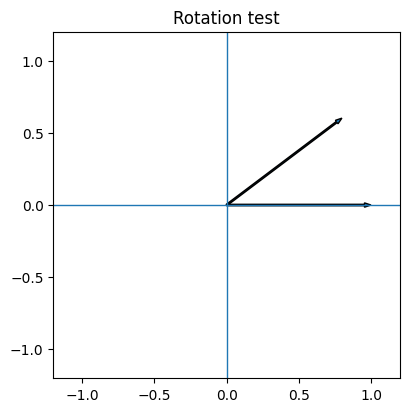

In [2]:
theta = 37.0 * np.pi / 180.0
R = rotation_matrix(theta)
I_err = np.linalg.norm(R.T @ R - np.eye(2))
print("||R^T R - I|| =", I_err)

v = np.array([1.0, 0.0])
v_rot = R @ v
print("v_rot =", v_rot)
print("|v|, |v_rot| =", np.linalg.norm(v), np.linalg.norm(v_rot))

fig, ax = plt.subplots(figsize=(4.5, 4.5))
ax.axhline(0, linewidth=1)
ax.axvline(0, linewidth=1)
ax.arrow(0, 0, v[0], v[1], width=0.01, length_includes_head=True)
ax.arrow(0, 0, v_rot[0], v_rot[1], width=0.01, length_includes_head=True)
ax.set_aspect("equal", "box")
ax.set_xlim(-1.2, 1.2)
ax.set_ylim(-1.2, 1.2)
ax.set_title("Rotation test")
plt.show()


Settings:
  Filtered Fourier: M=12, alpha=10.0, p=4
  Metrics exclude |x-k|<=0.01 around integers k
    Filtered Fourier | max|err|=3.789e-01  rms(err)=6.072e-02 | max|derr|=1.187e+01 rms(derr)=2.745e+00


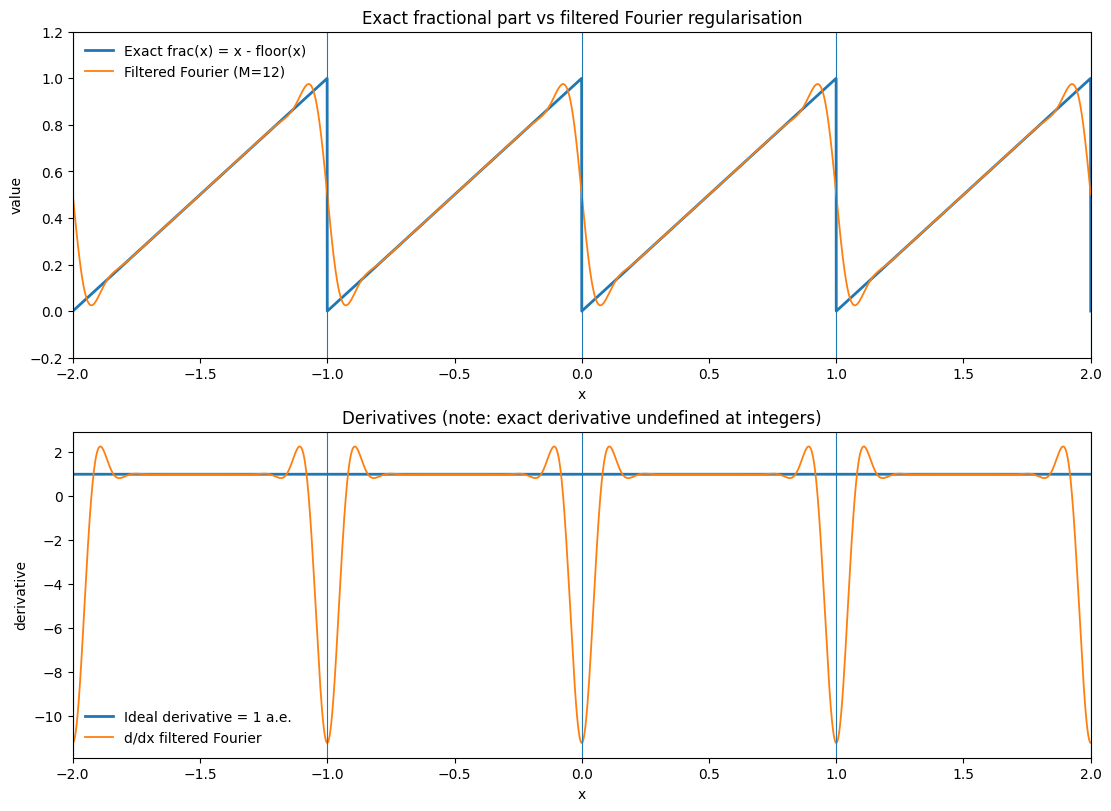

In [3]:
# Single-cell comparison:
#   - Exact fractional part frac(x) = x - floor(x)
#   - Filtered Fourier approximation (regularised Fourier)
# and their derivatives.

import numpy as np
import matplotlib.pyplot as plt

from latmatcher.core import (
    frac_fourier_filtered,
    d_frac_fourier_filtered_dx,
)

def frac_exact(x: np.ndarray) -> np.ndarray:
    x = np.asarray(x, dtype=float)
    return x - np.floor(x)

x = np.linspace(-2.0, 2.0, 8001)

M = 12
alpha = 10.0
p = 4

y_exact = frac_exact(x)
y_four = frac_fourier_filtered(x, M, alpha=alpha, p=p)
dy_four = d_frac_fourier_filtered_dx(x, M, alpha=alpha, p=p)

dy_ideal = np.ones_like(x)

eps_mask = 0.01
mask = np.ones_like(x, dtype=bool)
for k in range(-2, 3):
    mask &= np.abs(x - k) > eps_mask

err = np.abs(y_four - y_exact)
derr = np.abs(dy_four - dy_ideal)

print("Settings:")
print(f"  Filtered Fourier: M={M}, alpha={alpha}, p={p}")
print(f"  Metrics exclude |x-k|<={eps_mask} around integers k")
print(
    f"{'Filtered Fourier':>20s} | "
    f"max|err|={np.max(err[mask]):.3e}  rms(err)={np.sqrt(np.mean(err[mask]**2)):.3e} | "
    f"max|derr|={np.max(derr[mask]):.3e} rms(derr)={np.sqrt(np.mean(derr[mask]**2)):.3e}"
)

fig, ax = plt.subplots(2, 1, figsize=(11, 8), constrained_layout=True)

ax[0].plot(x, y_exact, linewidth=2, label="Exact frac(x) = x - floor(x)")
ax[0].plot(x, y_four, linewidth=1.3, label=f"Filtered Fourier (M={M})")
for k in range(-2, 3):
    ax[0].axvline(k, linewidth=0.8)
ax[0].set_xlim(-2, 2)
ax[0].set_ylim(-0.2, 1.2)
ax[0].set_xlabel("x")
ax[0].set_ylabel("value")
ax[0].set_title("Exact fractional part vs filtered Fourier regularisation")
ax[0].legend(frameon=False)

ax[1].plot(x, dy_ideal, linewidth=2, label="Ideal derivative = 1 a.e.")
ax[1].plot(x, dy_four, linewidth=1.3, label="d/dx filtered Fourier")
for k in range(-2, 3):
    ax[1].axvline(k, linewidth=0.8)
ax[1].set_xlim(-2, 2)
ax[1].set_xlabel("x")
ax[1].set_ylabel("derivative")
ax[1].set_title("Derivatives (note: exact derivative undefined at integers)")
ax[1].legend(frameon=False)

plt.show()


## 2) Known scaling case (B = 0.5 A)

The optimiser should find **positive strains** to expand B towards A.


In [4]:
A = hex_lattice(1.0)
B = hex_lattice(1.1)
m_set = make_index_set(40, 40)

bounds = [(-0.1, 0.1), (-0.1, 0.1), (0.0, 0.0)]
x0 = np.array([0.0, 0.0, 0.0])
C, grad = coverage_and_grad(x0, A, B, m_set, sigma=0.12, M=10, P=3)
print(C, grad)

x0 = [1/1.1-1,1/1.1-1,0.0]
C, grad = coverage_and_grad(x0, A, B, m_set, sigma=0.12, M=10, P=3)
print(C, grad)


xopt, Copt, info = maximise_coverage(A, B, m_set, bounds=bounds, x0=x0, sigma=0.12, M=10, P=3)

print("success:", info.success, "|", info.message)
print("xopt (s1, s2, theta rad) =", xopt)
print("theta (deg) =", xopt[2] * 180/np.pi)
print("coverage =", Copt)

#assert xopt[0] > 0.2 and xopt[1] > 0.2, "Expected positive strain to expand B"
print("Check passed: strains are positive and sizable")


17.551997392361226 [ 2.45589321e+02  2.45589321e+02 -1.27136724e-11]
0.09835692820964463 [-8.11866401e-11 -3.29885552e-11 -5.32794144e-12]
x= [-0.09090909 -0.09090909  0.        ]
success: True | CONVERGENCE: NORM OF PROJECTED GRADIENT <= PGTOL
xopt (s1, s2, theta rad) = [-0.09090909 -0.09090909  0.        ]
theta (deg) = 0.0
coverage = 0.09835692820964463
Check passed: strains are positive and sizable


### Visualise lattice points before/after


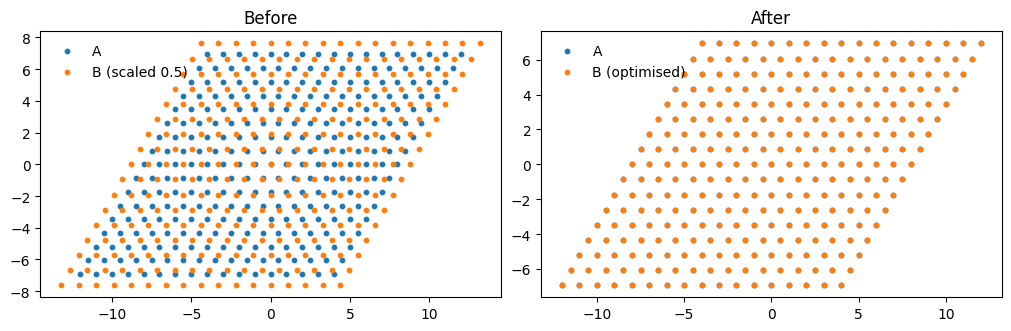

In [5]:
def lattice_points_xy(Lxy: np.ndarray, nmax: int = 8) -> np.ndarray:
    idx = make_index_set(2*nmax + 1, 2*nmax + 1) - np.array([nmax, nmax])
    return (Lxy @ idx.T).T

def transform_lattice_xy(Bxy: np.ndarray, params: np.ndarray) -> np.ndarray:
    s1, s2, theta = float(params[0]), float(params[1]), float(params[2])
    S = strain_matrix(s1, s2)
    RT = rotation_matrix(theta).T
    return S @ Bxy @ RT

nmax = 8
pts_A = lattice_points_xy(A, nmax)
pts_B0 = lattice_points_xy(B, nmax)
B_after = transform_lattice_xy(B, xopt)
pts_B1 = lattice_points_xy(B_after, nmax)

fig, ax = plt.subplots(1, 2, figsize=(10, 4), constrained_layout=True)
ax[0].scatter(pts_A[:,0], pts_A[:,1], s=10, label="A")
ax[0].scatter(pts_B0[:,0], pts_B0[:,1], s=10, label="B (scaled 0.5)")
ax[0].set_title("Before")
ax[0].set_aspect("equal", "box")
ax[0].legend(frameon=False)

ax[1].scatter(pts_A[:,0], pts_A[:,1], s=10, label="A")
ax[1].scatter(pts_B1[:,0], pts_B1[:,1], s=10, label="B (optimised)")
ax[1].set_title("After")
ax[1].set_aspect("equal", "box")
ax[1].legend(frameon=False)
plt.show()


## 3) Known rotation case

We restrict bounds around a target twist and check the optimiser stays near it.


In [19]:
import numpy as np
import matplotlib.pyplot as plt

from latmatcher.core import (
    hex_lattice,
    make_index_set,
    rotation_matrix,
)
from latmatcher.optim import maximise_coverage


# -----------------------
# Setup lattices
# -----------------------
A = hex_lattice(1.0)

deg2rad = np.pi/180
rad2deg = 180/np.pi

theta_target = 18.0 * deg2rad
B = A @ rotation_matrix(theta_target)

m_set = make_index_set(40, 40)

bounds = [(-0.1, 0.1), (-0.1, 0.1), (0.0, 0.0)]
x0 = np.array([0.0, 0.0, 0.0])
C, grad = coverage_and_grad(x0, A, B, m_set, sigma=0.12, M=10, P=3)
print(C, grad)

x0 = [0.0,0.0,theta_target]
C, grad = coverage_and_grad(x0, A, B, m_set, sigma=0.12, M=10, P=3)
print(C, grad)

19.778102595831704 [-38.7940077   76.55101082  18.74816802]
0.09835692820964463 [-4.62837401e-10  8.77942589e-11 -2.42004388e-10]


x= [0. 0. 0.]
x= [0.         0.         1.13561175]
x= [0.         0.         0.60320423]
x= [0.         0.         0.03674146]
x= [0.         0.         0.18816591]
x= [0.         0.         0.11166977]
x= [0.         0.         0.05785781]
x= [0.         0.         0.04232622]
x= [0.         0.         0.03986893]
x= [0.         0.         1.57079633]
x= [0.         0.         0.40918197]
x= [0.         0.         0.06091152]
x= [0.         0.         0.04051442]
x= [0.         0.         0.04015733]
x= [0.         0.         0.04015756]
success: True | CONVERGENCE: NORM OF PROJECTED GRADIENT <= PGTOL
theta_target (deg) = 18.0
theta_opt    (deg) = 2.3008587538397784
coverage = 1.203567105835517
Check passed: optimised angle is within 1 degree


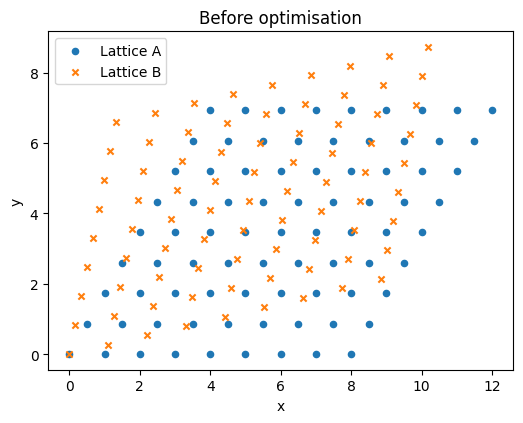

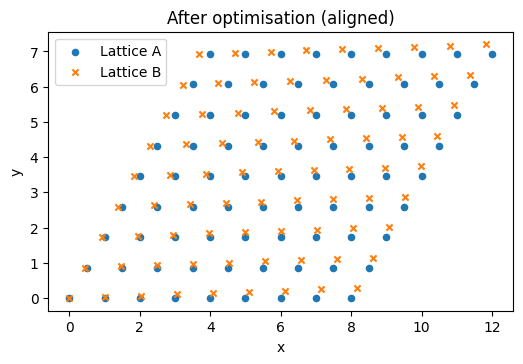

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from latmatcher.core import (
    hex_lattice,
    make_index_set,
    rotation_matrix,
)
from latmatcher.optim import maximise_coverage


# -----------------------
# Setup lattices
# -----------------------
A = hex_lattice(1.0)

deg2rad = np.pi/180
rad2deg = 180/np.pi

theta_target = 18.0 * deg2rad
B = A @ rotation_matrix(theta_target)


m_set = make_index_set(9, 9)

bounds = [
    (0.0, 0.0),
    (0.0, 0.0),
    (-90* deg2rad, 90* deg2rad),
]
x0 = np.array([0.0, 0.0, 0.0])


# -----------------------
# Optimisation
# -----------------------
xopt, Copt, info = maximise_coverage(
    A, B, m_set,
    bounds=bounds,
    x0=x0,
    M=10,
    P=3,
)

print(f"success: {info.success} | {info.message}")
print("theta_target (deg) =", theta_target * rad2deg)
print("theta_opt    (deg) =", xopt[2] * rad2deg)
print("coverage =", Copt)

#assert abs(xopt[2] - theta_target) < 1.0 * np.pi / 180.0
print("Check passed: optimised angle is within 1 degree")


# -----------------------
# Visualisation
# -----------------------
def plot_lattices(A, B, m_set, title):
    pts_A = (A @ m_set.T).T
    pts_B = (B @ m_set.T).T

    plt.scatter(
        pts_A[:, 0], pts_A[:, 1],
        s=20, c="tab:blue", label="Lattice A"
    )
    plt.scatter(
        pts_B[:, 0], pts_B[:, 1],
        s=20, c="tab:orange", marker="x", label="Lattice B"
    )
    plt.gca().set_aspect("equal")
    plt.legend()
    plt.title(title)
    plt.xlabel("x")
    plt.ylabel("y")


# Before optimisation
plt.figure(figsize=(6, 6))
plot_lattices(A, B, m_set, "Before optimisation")
plt.show()


# After optimisation
s1, s2, theta_opt = xopt
S = np.array([[1.0 + s1, 0.0], [0.0, 1.0 + s2]])
B_opt = S @ B @ rotation_matrix(theta_opt - theta_target)

plt.figure(figsize=(6, 6))
plot_lattices(A, B_opt, m_set, "After optimisation (aligned)")
plt.show()


## 4) CIF workflow: two CIFs → optimise → build bilayer CIF → plot

Set `cif_A` and `cif_B` paths, then run the cells.


In [7]:
# ---- set your CIF paths here ----
cif_A = "A.cif"  # host
cif_B = "B.cif"  # target
out_cif = "AB_bilayer.cif"

from latmatcher.cif import read_cif_atoms, lattice_xy_from_atoms, write_cif_atoms
from latmatcher.bilayer import build_bilayer_from_cifs

A_atoms = read_cif_atoms(cif_A)
B_atoms = read_cif_atoms(cif_B)
A_xy = lattice_xy_from_atoms(A_atoms)
B_xy = lattice_xy_from_atoms(B_atoms)

m_set = make_index_set(9, 9)
deg = np.pi/180.0
bounds = [(-0.03, 0.03), (-0.03, 0.03), (-3.0*deg, 3.0*deg)]

xopt, Copt, info = maximise_coverage(A_xy, B_xy, m_set, bounds=bounds, x0=np.array([0.0, 0.0, 0.0]))
print("success:", info["success"], "|", info["message"])
print("params: s1, s2, theta(deg)=", xopt[0], xopt[1], xopt[2]*180/np.pi)
print("coverage=", Copt)

combined = build_bilayer_from_cifs(
    cif_A, cif_B,
    params_B=(float(xopt[0]), float(xopt[1]), float(xopt[2])),
    interlayer_distance_A=10.0,
    vacuum_extra_A=10.0,
)
write_cif_atoms(combined, out_cif)
print("Wrote:", out_cif)


FileNotFoundError: [Errno 2] No such file or directory: 'A.cif'

### Plot the combined bilayer (xy projection)


In [ ]:
pos = combined.get_positions()
z = pos[:, 2]
z_mid = 0.5 * (z.min() + z.max())
mask_top = z > z_mid

fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(pos[~mask_top, 0], pos[~mask_top, 1], s=20, label="Layer (lower)")
ax.scatter(pos[mask_top, 0], pos[mask_top, 1], s=20, label="Layer (upper)")

cell = np.array(combined.cell)
a1 = cell[0, :2]
a2 = cell[1, :2]
ax.arrow(0.0, 0.0, a1[0], a1[1], width=0.02, length_includes_head=True)
ax.arrow(0.0, 0.0, a2[0], a2[1], width=0.02, length_includes_head=True)

ax.set_aspect("equal", "box")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("Combined bilayer (xy projection)")
ax.legend(frameon=False)
plt.show()
